In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../EDA/result3.csv')
df['location_count'] = df['location'].apply(lambda x: len(eval(x)))
df.drop('location',axis=1, inplace=True)
df

,programming language,tiobe index ratings,job amount,average salary,linkedin skill,avg wiki views (monthly),github user count,average search count,stack overflow count,location_count
0,Java,10.51,728,6.153528e+06,103000,3925.598214,6800,28.133930,2531,12
1,JavaScript,3.54,1111,6.168157e+06,118000,5276.794643,11400,15.482143,4633,12
2,Dart,0.56,32,6.250161e+06,945,52.953846,877,37.000000,963,6
3,Node.js,0.00,450,5.596209e+06,34000,662.803571,-1,2.633929,2207,8
4,PHP,1.21,505,5.762279e+06,123000,4083.750000,8600,26.616071,3147,11
...,...,...,...,...,...,...,...,...,...,...
170,Dc,0.00,1,5.592859e+06,0,-1.000000,-1,0.000000,0,1
171,VBScript,0.33,2,3.327448e+06,692,175.750000,-1,21.366070,0,1
172,CORAL,0.00,1,3.244448e+06,0,-1.000000,-1,0.000000,0,1
173,UniVerse,0.00,1,1.520833e+06,0,-1.000000,-1,0.000000,0,1


In [7]:
# standardize the data
scaler = StandardScaler()
df[['tiobe index ratings_T','job amount_T','average salary_T','linkedin skill_T',
    	'avg wiki views (monthly)_T','github user count_T','average search count_T',
        'stack overflow count_T','location_count_T']] = scaler.fit_transform(df[['tiobe index ratings','job amount',
        'average salary','linkedin skill',
    	'avg wiki views (monthly)','github user count','average search count',
        'stack overflow count','location_count']])

features_scaled = df[['tiobe index ratings_T','job amount_T','average salary_T','linkedin skill_T',
    	'avg wiki views (monthly)_T','github user count_T','average search count_T',
        'stack overflow count_T','location_count_T']]

In [38]:
from minisom import MiniSom

# Assuming features_scaled is a pandas DataFrame
features_scaled_arr = features_scaled.to_numpy()  # Convert DataFrame to NumPy array

# Define SOM grid dimensions
dimensions = [(10, 10), (12, 12), (15, 15), (20, 20)]
errors = []

# Train SOM with different grid sizes
for dim in dimensions:
    # Initialize SOM
    som = MiniSom(dim[0], dim[1], features_scaled_arr.shape[1], sigma=1.0, learning_rate=0.3)
    som.random_weights_init(features_scaled_arr)
    som.train_random(features_scaled_arr, 5000)  # 100 iterations
    
    # Compute quantization error and topographic error
    qe = som.quantization_error(features_scaled_arr)  # Quantization error
    te = som.topographic_error(features_scaled_arr)  # Topographic error
    
    errors.append((dim, qe, te))

# Find the optimal dimensions based on errors
optimal_dim = min(errors, key=lambda x: x[1] + x[2])
print(f"Optimal SOM dimensions: {optimal_dim[0]}, Quantization Error: {optimal_dim[1]}, Topographic Error: {optimal_dim[2]}")


Optimal SOM dimensions: (20, 20), Quantization Error: 0.06525477150317853, Topographic Error: 0.17714285714285713


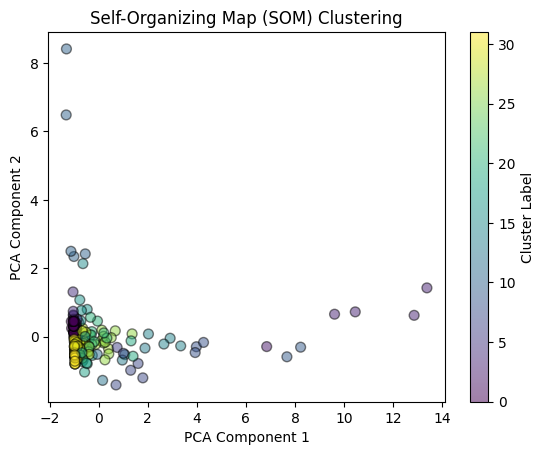

In [49]:
from sklearn.decomposition import PCA

features_scaled_arr = features_scaled.values

# Apply PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled_arr)

# Define SOM dimensions and initialize
som_dim = (6, 6)  # SOM grid dimensions, 20x20 grid
som = MiniSom(som_dim[0], som_dim[1], features_scaled_arr.shape[1], sigma=2.0, learning_rate=0.05)
som.random_weights_init(features_scaled_arr)  # Initialize weights randomly
# som.train_random(features_scaled_arr, 5000)  # Train for 1500 iterations
som.train_batch(features_scaled_arr, 5000)

# Get clusters by finding the winning node for each point
som_labels = np.array([som.winner(x) for x in features_scaled_arr])

# Map SOM coordinates to unique labels
unique_labels = {tuple(coord): idx for idx, coord in enumerate(np.unique(som_labels, axis=0))}
df['som_cluster'] = [unique_labels[tuple(coord)] for coord in som_labels]

# Plotting the results: PCA reduced data with cluster labels
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=df['som_cluster'], cmap='viridis', s=50, edgecolor='k',alpha=0.5)
plt.title("Self-Organizing Map (SOM) Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")  # Colorbar to indicate the cluster label
plt.show()

In [50]:
# Count the number of unique winning nodes
unique_winners = np.unique(som_labels, axis=0)
num_clusters = len(unique_winners)
print(f"Number of clusters in the SOM: {num_clusters}")

Number of clusters in the SOM: 32


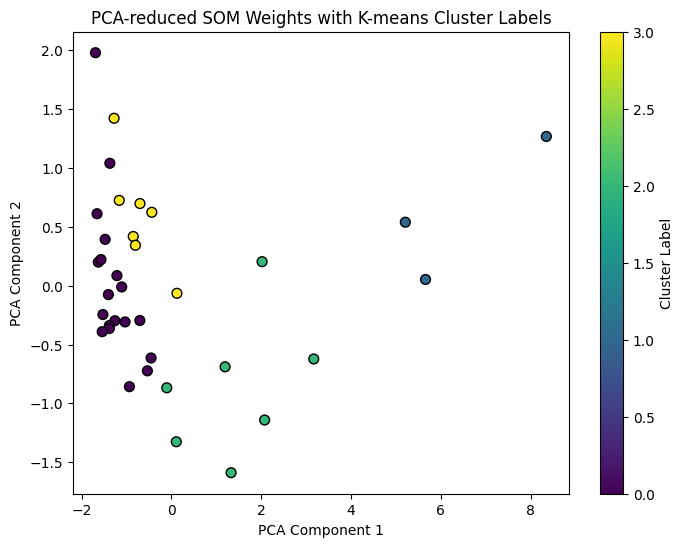

In [53]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flatten the SOM grid into a list of weights
som_weights = som.get_weights().reshape(-1, som.get_weights().shape[-1])

# Apply K-means clustering to the SOM weights
kmeans = KMeans(n_clusters=4)  # Choose the desired number of clusters
som_clusters = kmeans.fit_predict(som_weights)

# Map SOM grid cells to the K-means cluster labels
som_labels = som_clusters.reshape(som_dim[0], som_dim[1])

# Apply PCA to SOM weights for visualization
pca = PCA(n_components=2)
reduced_som_weights = pca.fit_transform(som_weights)

# Plot PCA-reduced SOM weights with K-means cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(reduced_som_weights[:, 0], reduced_som_weights[:, 1], c=som_clusters, cmap='viridis', s=50, edgecolor='k')
plt.title("PCA-reduced SOM Weights with K-means Cluster Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.show()
